In [27]:

# Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pathlib import Path
import shutil
import zipfile
import os

# 1) Google Drive RAF-DB.zip
raf_zip_path = Path("/content/drive/MyDrive/ColabData/datasets/RAF-DB.zip")
print("RAF zip path:", raf_zip_path)

if not raf_zip_path.exists():
    raise FileNotFoundError(f"Not found RAF-DB.zip: {raf_zip_path}")

#Copy to the local /content directory
local_zip_path = Path("/content/RAF-DB.zip")
if not local_zip_path.exists():
    shutil.copy(raf_zip_path, local_zip_path)
    print("Copied to local:", local_zip_path)
else:
    print("RAF-DB.zip already exists locally, skipping copying")


RAF zip path: /content/drive/MyDrive/ColabData/datasets/RAF-DB.zip
Copied to local: /content/RAF-DB.zip


In [4]:
#Unzip directory
raf_root = Path("/content/raf_db")
os.makedirs(raf_root, exist_ok=True)

# Only extract when the directory is empty to avoid wasting time due to repeated extraction.
if not any(raf_root.iterdir()):
    print("Start extracting to:", raf_root)
    with zipfile.ZipFile(local_zip_path, 'r') as zf:
        zf.extractall(raf_root)
    print("Unzipping completed")
else:
    print("It is found that the raf_root directory is not empty, indicating that it may have been decompressed already, so decompression is skipped.")

print("Final RAF root directory:", raf_root)


Start extracting to: /content/raf_db
Unzipping completed
Final RAF root directory: /content/raf_db


In [5]:
# Installation unrar
!apt-get install -y unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [6]:
#Extract RAF-DB.rar to a clean directory
!mkdir -p /content/raf_db/RAF-DB

!unrar x -inul "/content/raf_db/71b80-main/RAF-DB.rar" "/content/raf_db/RAF-DB/"
print("Unzipping completed.")

!ls -R /content/raf_db/RAF-DB | head -n 40


Unzipping completed.
/content/raf_db/RAF-DB:
RAF

/content/raf_db/RAF-DB/RAF:
train
valid

/content/raf_db/RAF-DB/RAF/train:
0
1
2
3
4
5
6

/content/raf_db/RAF-DB/RAF/train/0:
train_00006.jpg
train_00010.jpg
train_00012.jpg
train_00013.jpg
train_00032.jpg
train_00034.jpg
train_00043.jpg
train_00044.jpg
train_00053.jpg
train_00062.jpg
train_00068.jpg
train_00069.jpg
train_00072.jpg
train_00091.jpg
train_00104.jpg
train_00106.jpg
train_00107.jpg
train_00110.jpg
train_00111.jpg
train_00112.jpg
train_00113.jpg
train_00114.jpg
train_00125.jpg


In [7]:
from pathlib import Path

raf_root = Path('/content/raf_db/RAF-DB/RAF')
train_dir = raf_root / 'train'
val_dir   = raf_root / 'valid'

print("Train dir:", train_dir, train_dir.exists())
print("Val dir:",   val_dir,   val_dir.exists())


Train dir: /content/raf_db/RAF-DB/RAF/train True
Val dir: /content/raf_db/RAF-DB/RAF/valid True


In [8]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)

!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Define the number of categories. According to the RAF-DB dataset, it is usually 7 categories.
num_classes = 7

# ResNet18 pre-trained on ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  #num_classes=7 comes from the previous cell

model = model.to(device)

# Loss function: Adding a little label smoothing will make the generalization better.
criterion = nn.CrossEntropyLoss()

# Optimizer: SGD + momentum
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

# Learning Rate Scheduler: Cosine Annealing
num_epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Model saving path (can be modified as needed)
ckpt_dir = Path("/content/drive/MyDrive/CVproject/stage1/runs/raf_db")
ckpt_dir.mkdir(parents=True, exist_ok=True)
best_ckpt_path = ckpt_dir / "resnet18_rafdb_best.pth"

print("Checkpoint will be saved to:", best_ckpt_path)

device: cuda
Checkpoint will be saved to: /content/drive/MyDrive/CVproject/stage1/runs/raf_db/resnet18_rafdb_best.pth


In [38]:
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = eval_one_epoch(
        model, val_loader, criterion, device
    )

    # Update the learning rate
    scheduler.step()

    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
    print(f"Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.2f}%")

    # Save the model that performs best on the validation set
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": best_val_acc,
        }, best_ckpt_path)
        print(f"New best model saved! val_acc = {best_val_acc:.2f}%")

print("\nTraining finished.")
print(f"Best val_acc: {best_val_acc:.2f}%")


===== Epoch 1/20 =====


Train loss: 1.4968 | Train acc: 44.32%
Val   loss: 1.0415 | Val   acc: 62.19%
New best model saved! val_acc = 62.19%

===== Epoch 2/20 =====


Train loss: 0.9562 | Train acc: 65.33%
Val   loss: 1.0537 | Val   acc: 65.45%
New best model saved! val_acc = 65.45%

===== Epoch 3/20 =====


Train loss: 0.8113 | Train acc: 70.65%
Val   loss: 0.9632 | Val   acc: 67.11%
New best model saved! val_acc = 67.11%

===== Epoch 4/20 =====


Train loss: 0.7347 | Train acc: 72.97%
Val   loss: 0.6782 | Val   acc: 77.64%
New best model saved! val_acc = 77.64%

===== Epoch 5/20 =====


Train loss: 0.6282 | Train acc: 77.10%
Val   loss: 0.6484 | Val   acc: 78.03%
New best model saved! val_acc = 78.03%

===== Epoch 6/20 =====


Train loss: 0.5321 | Train acc: 81.35%
Val   loss: 0.6001 | Val   acc: 80.70%
New best model saved! val_acc = 80.70%

===== Epoch 7/20 =====


Train loss: 0.4782 | Train acc: 82.86%
Val   loss: 0.5691 | Val   acc: 82.01%
New best model saved! val_acc = 82.01%

===== Epoch 8/20 =====


Train loss: 0.4503 | Train acc: 83.81%
Val   loss: 0.5792 | Val   acc: 81.58%

===== Epoch 9/20 =====


Train loss: 0.3853 | Train acc: 86.33%
Val   loss: 0.5405 | Val   acc: 82.79%
New best model saved! val_acc = 82.79%

===== Epoch 10/20 =====


Train loss: 0.3581 | Train acc: 86.93%
Val   loss: 0.5079 | Val   acc: 84.88%
New best model saved! val_acc = 84.88%

===== Epoch 11/20 =====


Train loss: 0.2973 | Train acc: 89.19%
Val   loss: 0.6118 | Val   acc: 81.42%

===== Epoch 12/20 =====


Train loss: 0.2724 | Train acc: 90.38%
Val   loss: 0.5314 | Val   acc: 83.70%

===== Epoch 13/20 =====


Train loss: 0.2535 | Train acc: 91.03%
Val   loss: 0.5545 | Val   acc: 84.00%

===== Epoch 14/20 =====


Train loss: 0.2269 | Train acc: 91.92%
Val   loss: 0.5217 | Val   acc: 84.78%

===== Epoch 15/20 =====


Train loss: 0.1977 | Train acc: 93.05%
Val   loss: 0.5097 | Val   acc: 85.40%
New best model saved! val_acc = 85.40%

===== Epoch 16/20 =====


Train loss: 0.1823 | Train acc: 93.66%
Val   loss: 0.5010 | Val   acc: 85.23%

===== Epoch 17/20 =====


Train loss: 0.1776 | Train acc: 93.94%
Val   loss: 0.5053 | Val   acc: 85.53%
New best model saved! val_acc = 85.53%

===== Epoch 18/20 =====


Train loss: 0.1671 | Train acc: 94.31%
Val   loss: 0.5039 | Val   acc: 85.30%

===== Epoch 19/20 =====


Train loss: 0.1680 | Train acc: 94.09%
Val   loss: 0.4944 | Val   acc: 85.66%
New best model saved! val_acc = 85.66%

===== Epoch 20/20 =====


Train loss: 0.1572 | Train acc: 94.65%
Val   loss: 0.4942 | Val   acc: 85.72%
New best model saved! val_acc = 85.72%

Training finished.
Best val_acc: 85.72%


In [10]:
from tqdm.notebook import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100.0
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # No need for gradients
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Val  ", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100.0
    return epoch_loss, epoch_acc


In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

raf_root = Path("/content/raf_db/RAF-DB/RAF")
train_dir = raf_root / "train"
val_dir   = raf_root / "valid"

print("Train dir:", train_dir, "exists:", train_dir.exists())
print("Val dir:  ", val_dir, "exists:", val_dir.exists())

# A data augmentation that is slightly more aggressive than the baseline
train_tfms_stage2 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset2 = datasets.ImageFolder(str(train_dir), transform=train_tfms_stage2)
val_dataset2   = datasets.ImageFolder(str(val_dir),   transform=val_tfms)

batch_size = 128

train_loader2 = DataLoader(
    train_dataset2,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader2 = DataLoader(
    val_dataset2,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print("num_classes:", len(train_dataset2.classes))
print("num train batches:", len(train_loader2))
print("num val batches:", len(val_loader2))


Train dir: /content/raf_db/RAF-DB/RAF/train exists: True
Val dir:   /content/raf_db/RAF-DB/RAF/valid exists: True
num_classes: 7
num train batches: 96
num val batches: 24


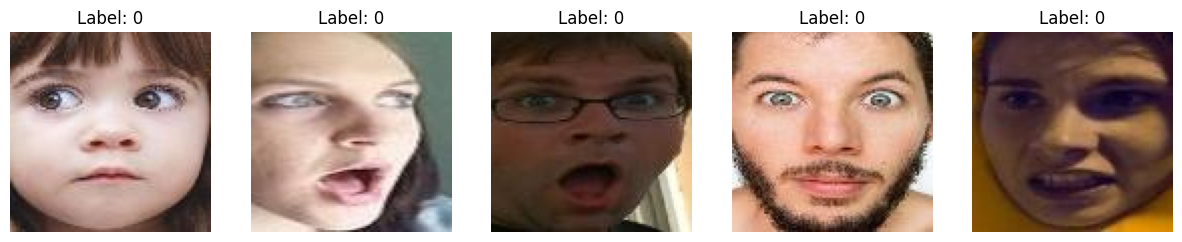

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder

# Get some image files
def show_sample_images(test_dir, num_images=5):
    # Data preprocessing steps
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the test set
    test_dataset = ImageFolder(root=test_dir)

    # Get the file name and label
    images, labels = zip(*[test_dataset[i] for i in range(num_images)])

    # Create a subgraph
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Convert the PIL image to a Tensor and then use permute
        img_tensor = transform(images[i])
        axes[i].imshow(img_tensor.permute(1, 2, 0))  # permute to [H, W, C]
        axes[i].set_title(f"Label: {test_dataset.classes[labels[i]]}")
        axes[i].axis('off')  # Do not display the coordinate axes

    plt.show()


test_dir = '/content/raf_db/RAF-DB/RAF/valid'
show_sample_images(test_dir)


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

# Define device globally for this cell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ExpressionEncoder class (copied from Cell 6 to make this cell self-contained)
class ExpressionEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        backbone = models.resnet18(weights=None)
        in_feats = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.proj_head = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, embed_dim),
        )

    def forward(self, x):
        feat = self.backbone(x)
        z = self.proj_head(feat)
        z = F.normalize(z, dim=-1)
        return z

# Assume fec_ckpt_path is from previous cells
fec_ckpt_path = Path("/content/drive/MyDrive/CVproject/stage1/runs/stage1_fec_metric/embedding_encoder_resnet18_triplet_final.pth")

# Instantiate the embedding model and load weights, ensuring it is on the correct device
embedding_model = ExpressionEncoder(embed_dim=128).to(device)  # Move model to device

if fec_ckpt_path.exists():
    # Load checkpoint to the correct device
    state = torch.load(fec_ckpt_path, map_location=device)
    embedding_model.load_state_dict(state, strict=True)
    print(" FEC encoder loaded for embedding extraction.")
else:
    print(f" FEC encoder checkpoint not found at {fec_ckpt_path}. Using randomly initialized model.")

embedding_model.eval()  # Set to evaluation mode

# Define data preprocessing (perform alignment, cropping, and scaling according to the training requirements of Stage-1)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the RAF-DB dataset
# Corrected root path for RAF-DB dataset based on previous cells
raf_db_dataset = datasets.ImageFolder(root='/content/raf_db/RAF-DB/RAF', transform=transform)
data_loader = DataLoader(raf_db_dataset, batch_size=32, shuffle=False)

# Extract embedding vectors
embeddings = []
labels = []
with torch.no_grad():
    for images, label in data_loader:
        images = images.to(device)  # Ensure that the input image is on the GPU.
        embeddings_batch = embedding_model(images)  # Extract embeddings
        embeddings.append(embeddings_batch.cpu().numpy())
        labels.append(label.cpu().numpy())

# Save the embedded vectors and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Save it in .npz format for easy subsequent use.
np.savez('raf_db_embeddings.npz', embeddings=embeddings, labels=labels)


 FEC encoder loaded for embedding extraction.


In [17]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.nn import functional as F
from tqdm import tqdm
import random
import numpy as np
from pathlib import Path

# ----------------------
# 0. 基本配置
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

raf_root = Path("/content/raf_db/RAF-DB")
train_dir = raf_root / "RAF" / "train"
val_dir   = raf_root / "RAF" / "valid"

assert train_dir.exists(), f"train_dir not found: {train_dir}"
assert val_dir.exists(),   f"val_dir not found: {val_dir}"

fec_ckpt_path = Path("/content/drive/MyDrive/CVproject/stage1/runs/stage1_fec_metric/embedding_encoder_resnet18_triplet_final.pth")
save_root = Path("/content/drive/MyDrive/CVproject/stage1/runs")
save_root.mkdir(parents=True, exist_ok=True)
save_path_best = save_root / "raf_stage1plus_best2.pth"


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Data augmentation & DataLoader

img_size = 224

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(str(train_dir), transform=train_tfms)
val_dataset   = datasets.ImageFolder(str(val_dir),   transform=val_tfms)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("num_classes:", num_classes)

batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers,
                          pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                          shuffle=False, num_workers=num_workers,
                          pin_memory=True)

print("num train batches:", len(train_loader))
print("num val batches:  ", len(val_loader))

#：ResNet18 + Embedding + Classifier

class RAFStage1Plus(nn.Module):
    def __init__(self, num_classes=7, embed_dim=128, pretrained_backbone=True):
        super().__init__()
        if pretrained_backbone:
            base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            base = models.resnet18(weights=None)

        in_features = base.fc.in_features
        base.fc = nn.Identity()

        self.encoder_backbone = base
        self.embedding = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim)
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_embedding=False):
        feat = self.encoder_backbone(x)
        emb  = self.embedding(feat)
        emb  = F.normalize(emb, p=2, dim=1)  # L2 norm
        logits = self.classifier(emb)
        if return_embedding:
            return logits, emb
        return logits

model = RAFStage1Plus(num_classes=num_classes, embed_dim=128,
                      pretrained_backbone=True).to(device)


# Load the pre-trained weights of the FEC encoder

def load_fec_into_raf(model, fec_ckpt_path, device):
    if not Path(fec_ckpt_path).exists():
        print(f"[WARN] FEC checkpoint not found: {fec_ckpt_path}")
        return model

    print(f"Loading FEC encoder weights from: {fec_ckpt_path}")
    ckpt = torch.load(fec_ckpt_path, map_location=device)

    # Load weights into the model
    model_state = model.state_dict()
    new_state = model_state.copy()

    matched = 0
    total = len(ckpt)

    for k, v in ckpt.items():
        new_k = None
        if k.startswith("backbone."):
            new_k = "encoder_backbone." + k[len("backbone."):]
        elif k.startswith("proj_head."):
            new_k = "embedding." + k[len("proj_head."):]
        elif k.startswith("embedding."):
            new_k = k

        if new_k is not None and new_k in new_state and new_state[new_k].shape == v.shape:
            new_state[new_k] = v
            matched += 1

    model.load_state_dict(new_state, strict=False)
    print(f"  Matched keys (after remap): {matched}/{total}")
    return model

model = load_fec_into_raf(model, fec_ckpt_path, device)


# Loss function & Triplet sampling

ce_criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)

def batch_hard_triplet_loss(embeddings, labels, margin=0.2):
    if embeddings.size(0) < 2:
        return torch.tensor(0.0, device=embeddings.device)

    dist_matrix = torch.cdist(embeddings, embeddings, p=2)
    labels = labels.unsqueeze(1)
    label_equal = (labels == labels.t())
    diag = torch.eye(dist_matrix.size(0), dtype=torch.bool,
                     device=embeddings.device)
    label_equal = label_equal & ~diag

    pos_dist = dist_matrix.clone()
    pos_dist[~label_equal] = -1
    hardest_pos, _ = pos_dist.max(dim=1)

    neg_dist = dist_matrix.clone()
    neg_dist[label_equal] = 1e9
    hardest_neg, _ = neg_dist.min(dim=1)

    valid_mask = (hardest_pos > 0) & (hardest_neg < 1e8)
    if valid_mask.sum() == 0:
        return torch.tensor(0.0, device=embeddings.device)

    hardest_pos = hardest_pos[valid_mask]
    hardest_neg = hardest_neg[valid_mask]

    triplet_loss = F.relu(hardest_pos - hardest_neg + margin)
    return triplet_loss.mean()

lambda_tri = 0.0

#Freeze / Unfreeze Settings

warmup_freeze_epochs = 5
total_epochs = 100

for name, p in model.named_parameters():
    if name.startswith("encoder_backbone"):
        p.requires_grad = False
    else:
        p.requires_grad = True

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=5e-4, weight_decay=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=warmup_freeze_epochs)


#Single epoch training/validation function

def run_epoch(model, loader, optimizer=None, epoch=0, stage="train"):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_ce   = 0.0
    total_tri  = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(loader, desc=f"{stage} Epoch {epoch:02d}", leave=False)
    for imgs, labels in loop:
        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits, emb = model(imgs, return_embedding=True)
            ce_loss  = ce_criterion(logits, labels)
            tri_loss = batch_hard_triplet_loss(emb, labels, margin=0.2)
            loss = ce_loss + lambda_tri * tri_loss

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        preds = logits.argmax(dim=1)
        correct = (preds == labels).sum().item()
        bs = labels.size(0)

        total_loss    += loss.item() * bs
        total_ce      += ce_loss.item() * bs
        total_tri     += tri_loss.item() * bs
        total_correct += correct
        total_samples += bs

        loop.set_postfix(loss=loss.item(),
                         ce=ce_loss.item(),
                         tri=tri_loss.item(),
                         acc=100.0 * correct / bs)

    avg_loss = total_loss / total_samples
    avg_ce   = total_ce   / total_samples
    avg_tri  = total_tri  / total_samples
    acc      = 100.0 * total_correct / total_samples

    return avg_loss, avg_ce, avg_tri, acc


#Training main loop

best_val_acc = 0.0

for epoch in range(1, total_epochs + 1):

    if epoch == warmup_freeze_epochs + 1:
        print("Unfreezing backbone, start fine-tuning all layers...")
        for p in model.parameters():
            p.requires_grad = True
        optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=(total_epochs - warmup_freeze_epochs))

    train_loss, train_ce, train_tri, train_acc = run_epoch(
        model, train_loader, optimizer, epoch, stage="Train"
    )
    val_loss, val_ce, val_tri, val_acc = run_epoch(
        model, val_loader, optimizer=None, epoch=epoch, stage="Valid"
    )

    if scheduler is not None:
        scheduler.step()

    print(f"Epoch [{epoch:02d}/{total_epochs}]")
    print(f"  Train: loss={train_loss:.4f} (CE={train_ce:.4f}, TRI={train_tri:.4f}), acc={train_acc:.2f}%")
    print(f"  Valid: loss={val_loss:.4f} (CE={val_ce:.4f}, TRI={val_tri:.4f}), acc={val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
        }, save_path_best)
        print(f" New best val acc: {best_val_acc:.2f}%, saved to {save_path_best}\n")
    else:
        print()

print("Training finished. Best val acc = {:.2f}%".format(best_val_acc))


#After the training is completed, load the best model and evaluate it again.

ckpt = torch.load(save_path_best, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.to(device).eval()

val_loss, val_ce, val_tri, val_acc = run_epoch(
    model, val_loader, optimizer=None, epoch=0, stage="Valid-Best"
)
print(" Final evaluation on valid (best model): acc = {:.2f}% ".format(val_acc))


Device: cuda
Classes: ['0', '1', '2', '3', '4', '5', '6']
num_classes: 7
num train batches: 384
num val batches:   96
Loading FEC encoder weights from: /content/drive/MyDrive/CVproject/stage1/runs/stage1_fec_metric/embedding_encoder_resnet18_triplet_final.pth
  Matched keys (after remap): 124/124


Epoch [01/100]
  Train: loss=1.6782 (CE=1.6782, TRI=1.1566), acc=41.65%
  Valid: loss=1.5848 (CE=1.5848, TRI=1.4994), acc=46.28%
  ✅ New best val acc: 46.28%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [02/100]
  Train: loss=1.6060 (CE=1.6060, TRI=1.3798), acc=42.94%
  Valid: loss=1.5474 (CE=1.5474, TRI=1.6493), acc=46.68%
  ✅ New best val acc: 46.68%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [03/100]
  Train: loss=1.5956 (CE=1.5956, TRI=1.4294), acc=43.17%
  Valid: loss=1.5431 (CE=1.5431, TRI=1.5771), acc=44.23%



Epoch [04/100]
  Train: loss=1.5817 (CE=1.5817, TRI=1.4650), acc=44.01%
  Valid: loss=1.5314 (CE=1.5314, TRI=1.6907), acc=47.39%
  ✅ New best val acc: 47.39%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [05/100]
  Train: loss=1.5755 (CE=1.5755, TRI=1.4606), acc=44.15%
  Valid: loss=1.5211 (CE=1.5211, TRI=1.6789), acc=47.88%
  ✅ New best val acc: 47.88%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth

🔓 Unfreezing backbone, start fine-tuning all layers...


Epoch [06/100]
  Train: loss=1.4071 (CE=1.4071, TRI=1.5309), acc=54.92%
  Valid: loss=1.2275 (CE=1.2275, TRI=1.7539), acc=66.82%
  ✅ New best val acc: 66.82%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [07/100]
  Train: loss=1.2547 (CE=1.2547, TRI=1.5236), acc=63.45%
  Valid: loss=1.1250 (CE=1.1250, TRI=1.6807), acc=72.72%
  ✅ New best val acc: 72.72%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [08/100]
  Train: loss=1.1701 (CE=1.1701, TRI=1.4947), acc=68.08%
  Valid: loss=1.0704 (CE=1.0704, TRI=1.6962), acc=74.51%
  ✅ New best val acc: 74.51%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [09/100]
  Train: loss=1.1081 (CE=1.1081, TRI=1.4713), acc=71.00%
  Valid: loss=1.0080 (CE=1.0080, TRI=1.6808), acc=77.44%
  ✅ New best val acc: 77.44%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [10/100]
  Train: loss=1.0555 (CE=1.0555, TRI=1.4556), acc=73.47%
  Valid: loss=0.9858 (CE=0.9858, TRI=1.6435), acc=76.96%



Epoch [11/100]
  Train: loss=1.0154 (CE=1.0154, TRI=1.4210), acc=74.77%
  Valid: loss=0.9382 (CE=0.9382, TRI=1.6633), acc=78.29%
  ✅ New best val acc: 78.29%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [12/100]
  Train: loss=0.9792 (CE=0.9792, TRI=1.4082), acc=76.46%
  Valid: loss=0.8957 (CE=0.8957, TRI=1.6658), acc=80.67%
  ✅ New best val acc: 80.67%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [13/100]
  Train: loss=0.9532 (CE=0.9532, TRI=1.3957), acc=77.53%
  Valid: loss=0.8900 (CE=0.8900, TRI=1.6214), acc=79.69%



Epoch [14/100]
  Train: loss=0.9225 (CE=0.9225, TRI=1.3933), acc=78.52%
  Valid: loss=0.8582 (CE=0.8582, TRI=1.6445), acc=81.06%
  ✅ New best val acc: 81.06%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [15/100]
  Train: loss=0.8946 (CE=0.8946, TRI=1.3791), acc=80.00%
  Valid: loss=0.8460 (CE=0.8460, TRI=1.6529), acc=82.53%
  ✅ New best val acc: 82.53%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [16/100]
  Train: loss=0.8770 (CE=0.8770, TRI=1.3725), acc=80.69%
  Valid: loss=0.8275 (CE=0.8275, TRI=1.5975), acc=82.56%
  ✅ New best val acc: 82.56%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [17/100]
  Train: loss=0.8518 (CE=0.8518, TRI=1.3454), acc=82.27%
  Valid: loss=0.8306 (CE=0.8306, TRI=1.6586), acc=83.15%
  ✅ New best val acc: 83.15%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [18/100]
  Train: loss=0.8391 (CE=0.8391, TRI=1.3292), acc=82.38%
  Valid: loss=0.8137 (CE=0.8137, TRI=1.6167), acc=83.64%
  ✅ New best val acc: 83.64%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [19/100]
  Train: loss=0.8127 (CE=0.8127, TRI=1.3181), acc=83.86%
  Valid: loss=0.8182 (CE=0.8182, TRI=1.6279), acc=83.25%



Epoch [20/100]
  Train: loss=0.8056 (CE=0.8056, TRI=1.3172), acc=84.23%
  Valid: loss=0.7982 (CE=0.7982, TRI=1.6305), acc=83.77%
  ✅ New best val acc: 83.77%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [21/100]
  Train: loss=0.7852 (CE=0.7852, TRI=1.2847), acc=84.76%
  Valid: loss=0.7869 (CE=0.7869, TRI=1.6286), acc=84.65%
  ✅ New best val acc: 84.65%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [22/100]
  Train: loss=0.7675 (CE=0.7675, TRI=1.2831), acc=85.89%
  Valid: loss=0.7802 (CE=0.7802, TRI=1.6370), acc=84.94%
  ✅ New best val acc: 84.94%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [23/100]
  Train: loss=0.7482 (CE=0.7482, TRI=1.2555), acc=86.64%
  Valid: loss=0.7718 (CE=0.7718, TRI=1.6180), acc=85.72%
  ✅ New best val acc: 85.72%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [24/100]
  Train: loss=0.7411 (CE=0.7411, TRI=1.2432), acc=86.68%
  Valid: loss=0.7916 (CE=0.7916, TRI=1.6446), acc=84.65%



Epoch [25/100]
  Train: loss=0.7316 (CE=0.7316, TRI=1.2267), acc=87.48%
  Valid: loss=0.7667 (CE=0.7667, TRI=1.5921), acc=85.40%



Epoch [26/100]
  Train: loss=0.7161 (CE=0.7161, TRI=1.2115), acc=87.87%
  Valid: loss=0.7800 (CE=0.7800, TRI=1.5872), acc=86.02%
  ✅ New best val acc: 86.02%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [27/100]
  Train: loss=0.7083 (CE=0.7083, TRI=1.2036), acc=88.40%
  Valid: loss=0.7616 (CE=0.7616, TRI=1.5965), acc=86.11%
  ✅ New best val acc: 86.11%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [28/100]
  Train: loss=0.6987 (CE=0.6987, TRI=1.1845), acc=88.71%
  Valid: loss=0.7738 (CE=0.7738, TRI=1.6070), acc=85.17%



Epoch [29/100]
  Train: loss=0.6893 (CE=0.6893, TRI=1.1673), acc=89.06%
  Valid: loss=0.7641 (CE=0.7641, TRI=1.5888), acc=85.46%



Epoch [30/100]
  Train: loss=0.6811 (CE=0.6811, TRI=1.1574), acc=89.37%
  Valid: loss=0.7566 (CE=0.7566, TRI=1.6145), acc=86.41%
  ✅ New best val acc: 86.41%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [31/100]
  Train: loss=0.6686 (CE=0.6686, TRI=1.1520), acc=90.01%
  Valid: loss=0.7629 (CE=0.7629, TRI=1.5905), acc=85.89%



Epoch [32/100]
  Train: loss=0.6603 (CE=0.6603, TRI=1.1239), acc=90.29%
  Valid: loss=0.7695 (CE=0.7695, TRI=1.5958), acc=85.89%



Epoch [33/100]
  Train: loss=0.6521 (CE=0.6521, TRI=1.1142), acc=90.79%
  Valid: loss=0.7568 (CE=0.7568, TRI=1.5973), acc=85.89%



Epoch [34/100]
  Train: loss=0.6447 (CE=0.6447, TRI=1.1099), acc=91.16%
  Valid: loss=0.7624 (CE=0.7624, TRI=1.6021), acc=86.21%



Epoch [35/100]
  Train: loss=0.6425 (CE=0.6425, TRI=1.1049), acc=91.37%
  Valid: loss=0.7649 (CE=0.7649, TRI=1.6071), acc=86.25%



Epoch [36/100]
  Train: loss=0.6366 (CE=0.6366, TRI=1.1025), acc=91.44%
  Valid: loss=0.7707 (CE=0.7707, TRI=1.5989), acc=86.21%



Epoch [37/100]
  Train: loss=0.6268 (CE=0.6268, TRI=1.0788), acc=91.94%
  Valid: loss=0.7766 (CE=0.7766, TRI=1.5836), acc=85.85%



Epoch [38/100]
  Train: loss=0.6250 (CE=0.6250, TRI=1.0769), acc=91.88%
  Valid: loss=0.7832 (CE=0.7832, TRI=1.5969), acc=85.43%



Epoch [39/100]
  Train: loss=0.6121 (CE=0.6121, TRI=1.0538), acc=92.38%
  Valid: loss=0.7792 (CE=0.7792, TRI=1.6167), acc=85.53%



Epoch [40/100]
  Train: loss=0.6023 (CE=0.6023, TRI=1.0283), acc=92.81%
  Valid: loss=0.7867 (CE=0.7867, TRI=1.6205), acc=85.23%



Epoch [41/100]
  Train: loss=0.6038 (CE=0.6038, TRI=1.0375), acc=93.07%
  Valid: loss=0.7689 (CE=0.7689, TRI=1.6176), acc=85.69%



Epoch [42/100]
  Train: loss=0.5942 (CE=0.5942, TRI=1.0234), acc=93.39%
  Valid: loss=0.7809 (CE=0.7809, TRI=1.6057), acc=85.56%



Epoch [43/100]
  Train: loss=0.5980 (CE=0.5980, TRI=1.0298), acc=92.90%
  Valid: loss=0.7905 (CE=0.7905, TRI=1.6138), acc=85.46%



Epoch [44/100]
  Train: loss=0.5868 (CE=0.5868, TRI=1.0111), acc=93.74%
  Valid: loss=0.7853 (CE=0.7853, TRI=1.5967), acc=85.72%



Epoch [45/100]
  Train: loss=0.5798 (CE=0.5798, TRI=0.9949), acc=94.08%
  Valid: loss=0.7784 (CE=0.7784, TRI=1.5826), acc=86.44%
  ✅ New best val acc: 86.44%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [46/100]
  Train: loss=0.5732 (CE=0.5732, TRI=0.9757), acc=94.39%
  Valid: loss=0.7689 (CE=0.7689, TRI=1.6011), acc=86.51%
  ✅ New best val acc: 86.51%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [47/100]
  Train: loss=0.5712 (CE=0.5712, TRI=0.9672), acc=94.45%
  Valid: loss=0.7706 (CE=0.7706, TRI=1.6140), acc=86.77%
  ✅ New best val acc: 86.77%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [48/100]
  Train: loss=0.5663 (CE=0.5663, TRI=0.9658), acc=94.46%
  Valid: loss=0.7656 (CE=0.7656, TRI=1.5826), acc=86.90%
  ✅ New best val acc: 86.90%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [49/100]
  Train: loss=0.5665 (CE=0.5665, TRI=0.9545), acc=94.56%
  Valid: loss=0.7736 (CE=0.7736, TRI=1.5794), acc=86.34%



Epoch [50/100]
  Train: loss=0.5629 (CE=0.5629, TRI=0.9552), acc=94.79%
  Valid: loss=0.7562 (CE=0.7562, TRI=1.5964), acc=86.73%



Epoch [51/100]
  Train: loss=0.5568 (CE=0.5568, TRI=0.9334), acc=95.04%
  Valid: loss=0.7704 (CE=0.7704, TRI=1.5938), acc=87.22%
  ✅ New best val acc: 87.22%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [52/100]
  Train: loss=0.5570 (CE=0.5570, TRI=0.9420), acc=94.90%
  Valid: loss=0.7782 (CE=0.7782, TRI=1.6444), acc=86.47%



Epoch [53/100]
  Train: loss=0.5550 (CE=0.5550, TRI=0.9311), acc=95.18%
  Valid: loss=0.7754 (CE=0.7754, TRI=1.5863), acc=86.80%



Epoch [54/100]
  Train: loss=0.5538 (CE=0.5538, TRI=0.9332), acc=95.05%
  Valid: loss=0.7807 (CE=0.7807, TRI=1.6099), acc=86.70%



Epoch [55/100]
  Train: loss=0.5426 (CE=0.5426, TRI=0.9114), acc=95.71%
  Valid: loss=0.7690 (CE=0.7690, TRI=1.6169), acc=87.19%



Epoch [56/100]
  Train: loss=0.5400 (CE=0.5400, TRI=0.9011), acc=95.66%
  Valid: loss=0.7974 (CE=0.7974, TRI=1.6516), acc=85.40%



Epoch [57/100]
  Train: loss=0.5422 (CE=0.5422, TRI=0.8985), acc=95.64%
  Valid: loss=0.7719 (CE=0.7719, TRI=1.6268), acc=86.77%



Epoch [58/100]
  Train: loss=0.5352 (CE=0.5352, TRI=0.8853), acc=95.97%
  Valid: loss=0.7752 (CE=0.7752, TRI=1.6321), acc=86.73%



Epoch [59/100]
  Train: loss=0.5243 (CE=0.5243, TRI=0.8546), acc=96.50%
  Valid: loss=0.7807 (CE=0.7807, TRI=1.6261), acc=86.73%



Epoch [60/100]
  Train: loss=0.5306 (CE=0.5306, TRI=0.8588), acc=96.25%
  Valid: loss=0.7961 (CE=0.7961, TRI=1.6403), acc=85.46%



Epoch [61/100]
  Train: loss=0.5348 (CE=0.5348, TRI=0.8751), acc=95.97%
  Valid: loss=0.7746 (CE=0.7746, TRI=1.6131), acc=86.77%



Epoch [62/100]
  Train: loss=0.5272 (CE=0.5272, TRI=0.8461), acc=96.47%
  Valid: loss=0.7921 (CE=0.7921, TRI=1.6199), acc=86.41%



Epoch [63/100]
  Train: loss=0.5206 (CE=0.5206, TRI=0.8441), acc=96.77%
  Valid: loss=0.7885 (CE=0.7885, TRI=1.5730), acc=86.11%



Epoch [64/100]
  Train: loss=0.5231 (CE=0.5231, TRI=0.8315), acc=96.43%
  Valid: loss=0.7747 (CE=0.7747, TRI=1.6184), acc=86.73%



Epoch [65/100]
  Train: loss=0.5204 (CE=0.5204, TRI=0.8412), acc=96.67%
  Valid: loss=0.7730 (CE=0.7730, TRI=1.5930), acc=86.99%



Epoch [66/100]
  Train: loss=0.5153 (CE=0.5153, TRI=0.8164), acc=97.04%
  Valid: loss=0.7822 (CE=0.7822, TRI=1.6140), acc=87.16%



Epoch [67/100]
  Train: loss=0.5177 (CE=0.5177, TRI=0.8263), acc=96.81%
  Valid: loss=0.7909 (CE=0.7909, TRI=1.6057), acc=86.67%



Epoch [68/100]
  Train: loss=0.5154 (CE=0.5154, TRI=0.8243), acc=96.96%
  Valid: loss=0.7819 (CE=0.7819, TRI=1.5983), acc=87.19%



Epoch [69/100]
  Train: loss=0.5126 (CE=0.5126, TRI=0.8037), acc=97.05%
  Valid: loss=0.7871 (CE=0.7871, TRI=1.6260), acc=86.28%



Epoch [70/100]
  Train: loss=0.5101 (CE=0.5101, TRI=0.8004), acc=96.98%
  Valid: loss=0.8026 (CE=0.8026, TRI=1.6398), acc=85.95%



Epoch [71/100]
  Train: loss=0.5139 (CE=0.5139, TRI=0.8173), acc=96.91%
  Valid: loss=0.7965 (CE=0.7965, TRI=1.6140), acc=86.41%



Epoch [72/100]
  Train: loss=0.5029 (CE=0.5029, TRI=0.7833), acc=97.51%
  Valid: loss=0.7812 (CE=0.7812, TRI=1.6045), acc=86.96%



Epoch [73/100]
  Train: loss=0.5043 (CE=0.5043, TRI=0.7830), acc=97.49%
  Valid: loss=0.7845 (CE=0.7845, TRI=1.6131), acc=86.80%



Epoch [74/100]
  Train: loss=0.5063 (CE=0.5063, TRI=0.7941), acc=97.22%
  Valid: loss=0.7844 (CE=0.7844, TRI=1.6106), acc=87.26%
  ✅ New best val acc: 87.26%, saved to /content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth



Epoch [75/100]
  Train: loss=0.4988 (CE=0.4988, TRI=0.7615), acc=97.66%
  Valid: loss=0.7929 (CE=0.7929, TRI=1.6219), acc=86.70%



Epoch [76/100]
  Train: loss=0.5021 (CE=0.5021, TRI=0.7675), acc=97.42%
  Valid: loss=0.7917 (CE=0.7917, TRI=1.6230), acc=86.70%



Epoch [77/100]
  Train: loss=0.5018 (CE=0.5018, TRI=0.7647), acc=97.49%
  Valid: loss=0.7970 (CE=0.7970, TRI=1.6274), acc=86.41%



Epoch [78/100]
  Train: loss=0.4992 (CE=0.4992, TRI=0.7607), acc=97.64%
  Valid: loss=0.7931 (CE=0.7931, TRI=1.6223), acc=86.60%



Epoch [79/100]
  Train: loss=0.4994 (CE=0.4994, TRI=0.7662), acc=97.51%
  Valid: loss=0.8095 (CE=0.8095, TRI=1.6211), acc=85.92%



Epoch [80/100]
  Train: loss=0.4929 (CE=0.4929, TRI=0.7276), acc=97.93%
  Valid: loss=0.7940 (CE=0.7940, TRI=1.6260), acc=86.64%



Epoch [81/100]
  Train: loss=0.4961 (CE=0.4961, TRI=0.7370), acc=97.73%
  Valid: loss=0.7955 (CE=0.7955, TRI=1.6278), acc=86.44%



Epoch [82/100]
  Train: loss=0.4914 (CE=0.4914, TRI=0.7269), acc=98.03%
  Valid: loss=0.7957 (CE=0.7957, TRI=1.6344), acc=86.57%



Epoch [83/100]
  Train: loss=0.4939 (CE=0.4939, TRI=0.7305), acc=97.86%
  Valid: loss=0.8010 (CE=0.8010, TRI=1.6095), acc=86.25%



Epoch [84/100]
  Train: loss=0.4968 (CE=0.4968, TRI=0.7455), acc=97.65%
  Valid: loss=0.7929 (CE=0.7929, TRI=1.6161), acc=86.67%



Epoch [85/100]
  Train: loss=0.4911 (CE=0.4911, TRI=0.7247), acc=98.03%
  Valid: loss=0.7966 (CE=0.7966, TRI=1.5964), acc=86.34%



Epoch [86/100]
  Train: loss=0.4904 (CE=0.4904, TRI=0.7239), acc=98.08%
  Valid: loss=0.7912 (CE=0.7912, TRI=1.6009), acc=86.70%



Epoch [87/100]
  Train: loss=0.4866 (CE=0.4866, TRI=0.7099), acc=98.17%
  Valid: loss=0.7927 (CE=0.7927, TRI=1.5971), acc=86.90%



Epoch [88/100]
  Train: loss=0.4922 (CE=0.4922, TRI=0.7304), acc=97.88%
  Valid: loss=0.7922 (CE=0.7922, TRI=1.6043), acc=86.93%



Epoch [89/100]
  Train: loss=0.4887 (CE=0.4887, TRI=0.7180), acc=98.06%
  Valid: loss=0.7885 (CE=0.7885, TRI=1.6262), acc=86.93%



Epoch [90/100]
  Train: loss=0.4876 (CE=0.4876, TRI=0.7133), acc=98.16%
  Valid: loss=0.7901 (CE=0.7901, TRI=1.6170), acc=86.77%



Epoch [91/100]
  Train: loss=0.4899 (CE=0.4899, TRI=0.7205), acc=98.03%
  Valid: loss=0.7892 (CE=0.7892, TRI=1.6092), acc=86.83%



Epoch [92/100]
  Train: loss=0.4872 (CE=0.4872, TRI=0.7129), acc=98.07%
  Valid: loss=0.7887 (CE=0.7887, TRI=1.6067), acc=86.73%



Epoch [93/100]
  Train: loss=0.4901 (CE=0.4901, TRI=0.7167), acc=98.00%
  Valid: loss=0.7942 (CE=0.7942, TRI=1.6048), acc=86.31%



Epoch [94/100]
  Train: loss=0.4881 (CE=0.4881, TRI=0.7199), acc=98.13%
  Valid: loss=0.7955 (CE=0.7955, TRI=1.6016), acc=86.34%



Epoch [95/100]
  Train: loss=0.4882 (CE=0.4882, TRI=0.7094), acc=98.07%
  Valid: loss=0.7940 (CE=0.7940, TRI=1.6066), acc=86.54%



Epoch [96/100]
  Train: loss=0.4896 (CE=0.4896, TRI=0.7216), acc=97.97%
  Valid: loss=0.7896 (CE=0.7896, TRI=1.6055), acc=86.86%



Epoch [97/100]
  Train: loss=0.4844 (CE=0.4844, TRI=0.7147), acc=98.28%
  Valid: loss=0.7924 (CE=0.7924, TRI=1.6121), acc=86.51%



Epoch [98/100]
  Train: loss=0.4911 (CE=0.4911, TRI=0.7159), acc=97.93%
  Valid: loss=0.7929 (CE=0.7929, TRI=1.6122), acc=86.41%



Epoch [99/100]
  Train: loss=0.4890 (CE=0.4890, TRI=0.7098), acc=98.06%
  Valid: loss=0.7910 (CE=0.7910, TRI=1.5984), acc=86.57%



Epoch [100/100]
  Train: loss=0.4847 (CE=0.4847, TRI=0.7135), acc=98.29%
  Valid: loss=0.7916 (CE=0.7916, TRI=1.6068), acc=86.60%

Training finished. Best val acc = 87.26%


✅ Final evaluation on valid (best model): acc = 87.26% 


Using device: cuda
Preparing data...
Validation samples: 3068
Classes: ['0', '1', '2', '3', '4', '5', '6']
Using class names: ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
Loading model...
 Model loaded successfully
Evaluating model on test set...


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 18.71it/s]



 MODEL EVALUATION RESULTS
 Top-1 Accuracy: 87.26%
 Macro-F1 Score: 79.46%
 Best epoch: 74

 Detailed Classification Report:
              precision    recall  f1-score   support

    Surprise     0.9013    0.8602    0.8802       329
        Fear     0.6176    0.5676    0.5915        74
     Disgust     0.7000    0.6125    0.6533       160
   Happiness     0.9430    0.9485    0.9457      1185
     Sadness     0.8372    0.8389    0.8380       478
       Anger     0.8117    0.7716    0.7911       162
     Neutral     0.8377    0.8882    0.8622       680

    accuracy                         0.8726      3068
   macro avg     0.8069    0.7839    0.7946      3068
weighted avg     0.8712    0.8726    0.8715      3068



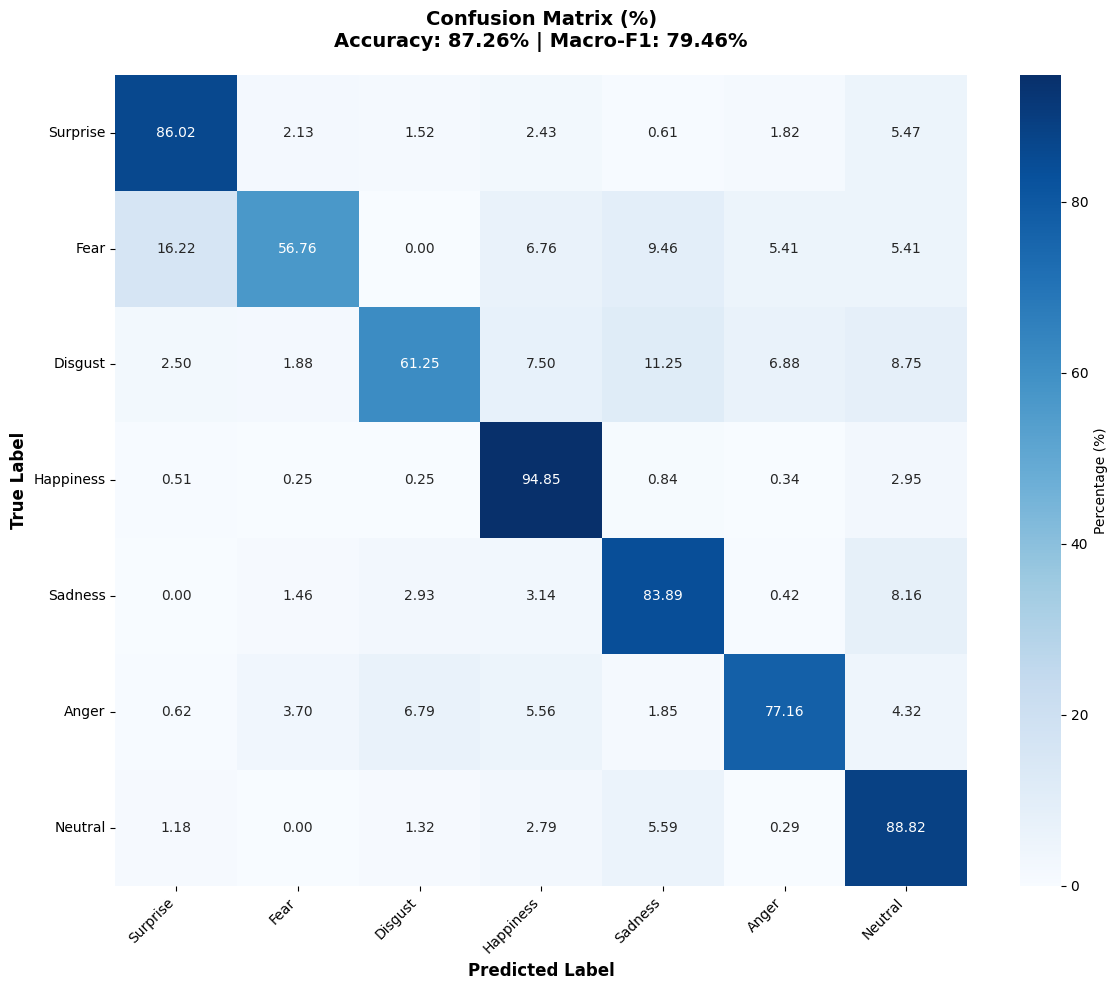

 Confusion matrix saved to: /content/drive/MyDrive/CVproject/stage1/runs/confusion_matrix.png

 PER-CLASS PERFORMANCE ANALYSIS
Class-wise Accuracy:
      Surprise:  86.02%  (283/329)
          Fear:  56.76%  ( 42/ 74)
       Disgust:  61.25%  ( 98/160)
     Happiness:  94.85%  (1124/1185)
       Sadness:  83.89%  (401/478)
         Anger:  77.16%  (125/162)
       Neutral:  88.82%  (604/680)

 Best class:  Happiness (94.85%)
 Worst class: Fear (56.76%)

 MOST COMMON CONFUSION PAIRS
Most common confusion pairs (True → Predicted):
       Sadness → Neutral     : 39 times ( 9.97% of errors)
       Neutral → Sadness     : 38 times ( 9.72% of errors)
     Happiness → Neutral     : 35 times ( 8.95% of errors)
       Neutral → Happiness   : 19 times ( 4.86% of errors)
      Surprise → Neutral     : 18 times ( 4.60% of errors)
       Disgust → Sadness     : 18 times ( 4.60% of errors)
       Sadness → Happiness   : 15 times ( 3.84% of errors)
       Disgust → Neutral     : 14 times ( 3.58% of e

In [40]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from tqdm import tqdm
from pathlib import Path




MODEL_PATH = "/content/drive/MyDrive/CVproject/stage1/runs/raf_stage1plus_best2.pth"

DATA_ROOT = "/content/raf_db/RAF-DB"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Model Definition
class RAFStage1Plus(nn.Module):
    def __init__(self, num_classes=7, embed_dim=128, pretrained_backbone=True):
        super().__init__()
        if pretrained_backbone:
            base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            base = models.resnet18(weights=None)

        in_features = base.fc.in_features
        base.fc = nn.Identity()

        self.encoder_backbone = base
        self.embedding = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim)
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_embedding=False):
        feat = self.encoder_backbone(x)
        emb = self.embedding(feat)
        emb = F.normalize(emb, p=2, dim=1)  # L2 norm

        if return_embedding:
            return self.classifier(emb), emb
        else:
            return self.classifier(emb)


# Data loading function

def prepare_data_loaders(data_root):
    data_path = Path(data_root)
    val_dir = data_path / "RAF" / "valid"

    if not val_dir.exists():
        print(f" Validation directory not found: {val_dir}")
        print("Please check your DATA_ROOT path")
        return None, None

    # Validation set preprocessing
    val_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
    ])

    # Load the validation set
    val_dataset = datasets.ImageFolder(str(val_dir), transform=val_tfms)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    print(f"Validation samples: {len(val_dataset)}")
    print(f"Classes: {val_dataset.classes}")

    return val_loader, val_dataset.classes


# Evaluation function
def evaluate_model(model, test_loader, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    print("Evaluating model on test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluation"):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return all_preds, all_labels, all_probs

def plot_confusion_matrix(cm_percentage, class_names, top1_accuracy, macro_f1, save_path):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percentage,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'},
                annot_kws={'size': 10})

    plt.title(f'Confusion Matrix (%)\nAccuracy: {top1_accuracy:.2f}% | Macro-F1: {macro_f1:.2f}%',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def analyze_class_performance(all_labels, all_preds, class_names):

    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))

    for i in range(len(class_names)):
        mask = (all_labels == i)
        class_total[i] = mask.sum()
        if class_total[i] > 0:
            class_correct[i] = (all_preds[mask] == all_labels[mask]).sum()

    class_accuracy = (class_correct / class_total) * 100
    return class_correct, class_total, class_accuracy

def print_error_analysis(all_labels, all_preds, class_names):

    error_pairs = []
    for true_label, pred_label in zip(all_labels, all_preds):
        if true_label != pred_label:
            error_pairs.append((true_label, pred_label))

    error_counter = Counter(error_pairs)

    print("Most common confusion pairs (True → Predicted):")
    for (true_idx, pred_idx), count in error_counter.most_common(10):
        true_class = class_names[true_idx]
        pred_class = class_names[pred_idx]
        percentage = (count / len(error_pairs)) * 100 if len(error_pairs) > 0 else 0
        print(f"  {true_class:>12} → {pred_class:<12}: {count:>2} times ({percentage:5.2f}% of errors)")


# Main evaluation process

def main_evaluation():
    # Check the model path
    model_path = Path(MODEL_PATH)
    if not model_path.exists():
        print(f"Model not found: {model_path}")
        print("Please check your MODEL_PATH")
        return

    # Prepare data
    print("Preparing data...")
    val_loader, dataset_classes = prepare_data_loaders(DATA_ROOT)
    if val_loader is None:
        return

    # RAF-DB Standard Category Names
    raf_class_names = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

    # Check if the number of categories matches
    if len(dataset_classes) != len(raf_class_names):
        print(f"  Dataset has {len(dataset_classes)} classes, using numeric labels")
        class_names = [str(i) for i in range(len(dataset_classes))]
    else:
        class_names = raf_class_names

    print(f"Using class names: {class_names}")

    # Loading model
    print("Loading model...")
    try:
        checkpoint = torch.load(model_path, map_location=device)

        # Create a model instance
        model = RAFStage1Plus(num_classes=len(class_names), embed_dim=128, pretrained_backbone=True).to(device)

        #Load weights
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        elif 'model_state' in checkpoint:
            model.load_state_dict(checkpoint['model_state'])
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            # state_dict
            model.load_state_dict(checkpoint)

        model.eval()
        print(" Model loaded successfully")

    except Exception as e:
        print(f" Error loading model: {e}")
        return

    # Conduct an evaluation
    all_preds, all_labels, all_probs = evaluate_model(model, val_loader, class_names)

    # Calculate indicators
    top1_accuracy = np.mean(all_preds == all_labels) * 100
    macro_f1 = f1_score(all_labels, all_preds, average='macro') * 100

    # Print the main results
    print("\n" + "="*60)
    print(" MODEL EVALUATION RESULTS")
    print("="*60)
    print(f" Top-1 Accuracy: {top1_accuracy:.2f}%")
    print(f" Macro-F1 Score: {macro_f1:.2f}%")


    if 'val_acc' in checkpoint:
        print(f" Training best val_acc: {checkpoint['val_acc']:.2f}%")
    if 'epoch' in checkpoint:
        print(f" Best epoch: {checkpoint['epoch']}")
    print("="*60)


    print("\n Detailed Classification Report:")
    print(classification_report(all_labels, all_preds,
                              target_names=class_names,
                              digits=4))


    cm = confusion_matrix(all_labels, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


    save_dir = model_path.parent
    confusion_matrix_path = save_dir / "confusion_matrix.png"
    plot_confusion_matrix(cm_percentage, class_names, top1_accuracy, macro_f1, confusion_matrix_path)
    print(f" Confusion matrix saved to: {confusion_matrix_path}")

    print("\n" + "="*60)
    print(" PER-CLASS PERFORMANCE ANALYSIS")
    print("="*60)

    class_correct, class_total, class_accuracy = analyze_class_performance(all_labels, all_preds, class_names)

    print("Class-wise Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name:>12}: {class_accuracy[i]:6.2f}%  ({int(class_correct[i]):>3}/{int(class_total[i]):>3})")

    # Identify the best-performing and worst-performing categories
    best_class_idx = np.argmax(class_accuracy)
    worst_class_idx = np.argmin(class_accuracy)
    print(f"\n Best class:  {class_names[best_class_idx]} ({class_accuracy[best_class_idx]:.2f}%)")
    print(f" Worst class: {class_names[worst_class_idx]} ({class_accuracy[worst_class_idx]:.2f}%)")

    # Error Analysis
    print("\n" + "="*60)
    print(" MOST COMMON CONFUSION PAIRS")
    print("="*60)
    print_error_analysis(all_labels, all_preds, class_names)

    total_errors = len([1 for true, pred in zip(all_labels, all_preds) if true != pred])
    total_samples = len(all_labels)
    error_rate = (total_errors / total_samples) * 100
    print(f"\nTotal misclassifications: {total_errors}/{total_samples} ({error_rate:.2f}%)")

    # Confidence analysis
    print("\n" + "="*60)
    print(" CONFIDENCE ANALYSIS")
    print("="*60)

    correct_mask = (all_preds == all_labels)
    if np.any(correct_mask):
        correct_confidences = np.max(all_probs[correct_mask], axis=1)
        avg_correct_confidence = np.mean(correct_confidences) * 100
    else:
        avg_correct_confidence = 0

    if np.any(~correct_mask):
        incorrect_confidences = np.max(all_probs[~correct_mask], axis=1)
        avg_incorrect_confidence = np.mean(incorrect_confidences) * 100
    else:
        avg_incorrect_confidence = 0

    overall_confidence = np.mean(np.max(all_probs, axis=1)) * 100

    print(f"Average confidence for correct predictions:   {avg_correct_confidence:.2f}%")
    print(f"Average confidence for incorrect predictions: {avg_incorrect_confidence:.2f}%")
    print(f"Overall average confidence:                   {overall_confidence:.2f}%")

    print("\n" + "="*60)
    print(" SAVING RESULTS")
    print("="*60)


    results_df = pd.DataFrame({
        'metric': ['Top-1 Accuracy', 'Macro-F1'],
        'value': [top1_accuracy, macro_f1],
        'percentage': [f"{top1_accuracy:.2f}%", f"{macro_f1:.2f}%"]
    })

    # Save the prediction result of each sample
    detailed_results = pd.DataFrame({
        'true_label': all_labels,
        'predicted_label': all_preds,
        'correct': (all_preds == all_labels),
        'confidence': np.max(all_probs, axis=1) * 100
    })
    detailed_results['true_class'] = [class_names[i] for i in all_labels]
    detailed_results['predicted_class'] = [class_names[i] for i in all_preds]

    results_csv_path = save_dir / "evaluation_results.csv"
    detailed_csv_path = save_dir / "detailed_predictions.csv"

    results_df.to_csv(results_csv_path, index=False)
    detailed_results.to_csv(detailed_csv_path, index=False)

    print(f" Evaluation results saved to: {results_csv_path}")
    print(f"Detailed predictions saved to: {detailed_csv_path}")
    print("\n Evaluation completed!")

# 运行评估
if __name__ == "__main__":
    main_evaluation()